# UKB OMOP EDA 

Using omop databases

Drugs for this study: loperamide, methadone,fentanyl, morphine, sufentanil.
Sufentanil does not appear in the omop database(after searching in the drug_era_atc.tsv).

In [1]:
!pip install upsetplot
!pip install scikit-learn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for upsetplot: filename=UpSetPlot-0.9.0-py3-none-any.whl size=24819 sha256=a0a1b3aa178ddc6f5a099bd832752354e2591dd2a7c1b3c4c1adf0b584b00899
  Stored in directory: /tmp/pip-ephem-wheel-cache-bip8da21/wheels/d5/0b/03/a5c18ed188619e137e6f170bdb21d745dcf5507cf0d5a2950b
Successfully built upsetplot
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 80.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 110.5 MB/s eta 0:00:00


In [2]:
import pyspark
import dxpy
import dxdata
from pyspark.sql.functions import col, to_date

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from upsetplot import UpSet
from sklearn.preprocessing import StandardScaler

First obtain the drug id with drug_era_atc.tsv table and the atc_dict.py to obtain the ATC of each drug.

In [3]:
# Load the table
df = pd.read_csv("drug_era_atc.tsv", sep="\t")

# List of drugs to filter
drugs_to_filter = ["loperamide", "methadone", "fentanyl", "morphine"]

# Filter rows where the drug name is in the list of drugs to filter
filtered_df = df[df["concept_name"].isin(drugs_to_filter)]

# Select the required columns and rename _c13 to ATC
filtered_df = filtered_df[
    [
        "drug_concept_id",
        "concept_name",
        "domain_id",
        "concept_class_id",
        "concept_code",
        "valid_start_date",
        "valid_end_date",
        "invalid_reason",
        "_c13",
    ]
]

# Rename the _c13 column to ATC
filtered_df.rename(columns={"_c13": "ATC"}, inplace=True)

filtered_df

,drug_concept_id,concept_name,domain_id,concept_class_id,concept_code,valid_start_date,valid_end_date,invalid_reason,ATC
64,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N01AH01
65,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N02AB03
101,1103640,methadone,Drug,Ingredient,6813,1970-01-01,2099-12-31,NaN,N07BC02
421,991876,loperamide,Drug,Ingredient,6468,1970-01-01,2099-12-31,NaN,A07DA03
1413,1110410,morphine,Drug,Ingredient,7052,1970-01-01,2099-12-31,NaN,N02AA01


In [4]:
# Import the ATC dictionaries from atc_dict.py
from atc_dict import atc_first_level_full_list, atc_second_level_full_list

# Map first level ATC codes
filtered_df["ATC_First_Level"] = filtered_df["ATC"].apply(
    lambda x: x[0] if isinstance(x, str) else None
)
filtered_df["ATC_Second_Level"] = filtered_df["ATC"].apply(
    lambda x: x[:3] if isinstance(x, str) else None
)

# Map the names of the first and second level ATC categories using the imported dictionaries
filtered_df["First_Level_Name"] = filtered_df["ATC_First_Level"].map(
    atc_first_level_full_list
)
filtered_df["Second_Level_Name"] = filtered_df["ATC_Second_Level"].map(
    lambda x: atc_second_level_full_list.get(x[0], {}).get(x, "Unknown")
)

filtered_df

,drug_concept_id,concept_name,domain_id,concept_class_id,concept_code,valid_start_date,valid_end_date,invalid_reason,ATC,ATC_First_Level,ATC_Second_Level,First_Level_Name,Second_Level_Name
64,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N01AH01,N,N01,Nervous System,Anesthetics
65,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N02AB03,N,N02,Nervous System,Analgesics
101,1103640,methadone,Drug,Ingredient,6813,1970-01-01,2099-12-31,NaN,N07BC02,N,N07,Nervous System,Other Nervous System Drugs
421,991876,loperamide,Drug,Ingredient,6468,1970-01-01,2099-12-31,NaN,A07DA03,A,A07,Alimentary Tract and Metabolism,"Antidiarrheals, Intestinal Anti-inflammatory/A..."
1413,1110410,morphine,Drug,Ingredient,7052,1970-01-01,2099-12-31,NaN,N02AA01,N,N02,Nervous System,Analgesics


In [5]:
# Save the filtered table to a new file
filtered_df.to_csv("filtered_drug_atc.tsv", sep="\t", index=False)

Now we can obtain the omop data bases from UK Biobank and filter for the drugs ids of interest

In [6]:
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc)

dispensed_database_name = dxpy.find_one_data_object(
    classname="database", name="app*", folder="/", name_mode="glob", describe=True
)["describe"]["name"]
dispensed_dataset_id = dxpy.find_one_data_object(
    typename="Dataset", name="app*.dataset", folder="/", name_mode="glob"
)["id"]

spark.sql("USE " + dispensed_database_name)

dataset = dxdata.load_dataset(id=dispensed_dataset_id)

In [7]:
# Init pyspark and load dataframe
# Load the 'omop_drug_era' 'omop_drug_exposure' and 'omop_person' tables
omop_drug_era = "omop_drug_era"
omop_drug_exposure = "omop_drug_exposure"
omop_person = "omop_person"
# Load tables
drug_era = dataset[omop_drug_era]
drug_exposure = dataset[omop_drug_exposure]
person = dataset[omop_person]

# Extract all field names from the tables
field_names_era = [f.name for f in drug_era.fields]
field_names_exposure = [f.name for f in drug_exposure.fields]
field_names_person = [f.name for f in person.fields]

# Retrieve the fields
df_era = drug_era.retrieve_fields(names=field_names_era, engine=dxdata.connect())
df_exposure = drug_exposure.retrieve_fields(
    names=field_names_exposure, engine=dxdata.connect()
)
df_person = person.retrieve_fields(names=field_names_person, engine=dxdata.connect())

print(df_era.columns)
print(df_exposure.columns)
print(df_person.columns)

print(f"Number of entries era {df_era.count()}")
print(f"Number of entries exposure {df_exposure.count()}")
print(f"Number of entries person {df_person.count()}")
df_era.drop("eid").show(3, truncate=False)
df_exposure.drop("eid").show(3, truncate=False)
df_person.drop("eid").show(3, truncate=False)

['eid', 'drug_era_id', 'drug_concept_id', 'drug_era_start_date', 'drug_era_end_date', 'drug_exposure_count', 'gap_days']
['eid', 'drug_exposure_id', 'drug_concept_id', 'drug_exposure_start_date', 'drug_exposure_start_datetime', 'drug_exposure_end_date', 'drug_exposure_end_datetime', 'verbatim_end_date', 'drug_type_concept_id', 'stop_reason', 'refills', 'quantity', 'days_supply', 'sig', 'route_concept_id', 'lot_number', 'provider_id', 'visit_occurrence_id', 'visit_detail_id', 'drug_source_value', 'drug_source_concept_id', 'route_source_value', 'dose_unit_source_value']
['eid', 'gender_concept_id', 'year_of_birth', 'month_of_birth', 'day_of_birth', 'birth_datetime', 'race_concept_id', 'ethnicity_concept_id', 'location_id', 'provider_id', 'care_site_id', 'person_source_value', 'gender_source_value', 'gender_source_concept_id', 'race_source_value', 'race_source_concept_id', 'ethnicity_source_value', 'ethnicity_source_concept_id']
Number of entries era 19959413
Number of entries exposure 55

In [8]:
# Load the `filtered_drug_atc.tsv` file as a Pandas DataFrame
drug_mapping_df = pd.read_csv("filtered_drug_atc.tsv", sep="\t")
# Extract `drug_concept_id` values as a list
drug_concept_ids = drug_mapping_df["drug_concept_id"].dropna().unique().tolist()
drug_concept_ids

[1154029, 1103640, 991876, 1110410]

In [9]:
# Filter the OMOP dataset for relevant drug_concept_id
filtered_df_era = df_era.filter(col("drug_concept_id").isin(drug_concept_ids))
# Format date columns
filtered_df_era = filtered_df_era.withColumn(
    "drug_era_start_date", to_date(col("drug_era_start_date"), "MM/dd/yyyy")
).withColumn("drug_era_end_date", to_date(col("drug_era_end_date"), "MM/dd/yyyy"))

# Merge with person_df on the 'eid' column to keep information about the person
# Select only the required columns from df_person
df_person_selected = df_person.select("eid", "gender_concept_id", "year_of_birth")

# Perform a left join with filtered_df_era on the 'eid' column
filtered_df_era = filtered_df_era.join(
    df_person_selected,
    on="eid",
    how="left",  # Perform a left join
)
# Show the result of the filter
filtered_df_era.drop("eid").show(truncate=False)
filtered_df_era.count()

+-------------+---------------+-------------------+-----------------+-------------------+--------+-----------------+-------------+
|drug_era_id  |drug_concept_id|drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|gender_concept_id|year_of_birth|
+-------------+---------------+-------------------+-----------------+-------------------+--------+-----------------+-------------+
|730144538282 |1110410        |null               |null             |2                  |0       |8532             |1951         |
|1176821107656|991876         |null               |2014-08-08       |1                  |0       |8532             |1949         |
|17179961333  |991876         |null               |null             |1                  |0       |8507             |1954         |
|1400159383219|991876         |2011-03-06         |null             |2                  |0       |8532             |1959         |
|1700807107514|991876         |2007-07-11         |2007-12-11       |1             

72395

In [10]:
# Filter the OMOP drug exposure dataset for relevant drug_concept_id
filtered_df_exposure = df_exposure.filter(col("drug_concept_id").isin(drug_concept_ids))
# Define the relevant columns for EDA
relevant_columns = [
    "eid",
    "drug_concept_id",
    "drug_exposure_start_date",
    "drug_exposure_end_date",
    "stop_reason",
    "refills",
    "days_supply",  # you can keep this to analyze duration or adherence
    "quantity",  # optional, can help to understand quantity per exposure
]

# Filter out the columns that are relevant for the EDA
filtered_df_exposure = filtered_df_exposure.select(relevant_columns)

# Format the date columns (if necessary)
filtered_df_exposure = filtered_df_exposure.withColumn(
    "drug_exposure_start_date", to_date(col("drug_exposure_start_date"), "MM/dd/yyyy")
).withColumn(
    "drug_exposure_end_date", to_date(col("drug_exposure_end_date"), "MM/dd/yyyy")
)

# Merge with person_df on the 'eid' column to keep information about the person
# Perform a left join with filtered_df_exposure on the 'eid' column
filtered_df_exposure = filtered_df_exposure.join(
    df_person_selected,
    on="eid",
    how="left",  # Perform a left join
)
# Show the result of the filter
filtered_df_exposure.drop("eid").show(truncate=False)
filtered_df_exposure.count()

+---------------+------------------------+----------------------+-----------+-------+-----------+--------+-----------------+-------------+
|drug_concept_id|drug_exposure_start_date|drug_exposure_end_date|stop_reason|refills|days_supply|quantity|gender_concept_id|year_of_birth|
+---------------+------------------------+----------------------+-----------+-------+-----------+--------+-----------------+-------------+
|1110410        |null                    |null                  |null       |null   |null       |1       |8507             |1966         |
|1110410        |null                    |null                  |null       |null   |null       |1       |8507             |1966         |
|1110410        |2014-08-04              |2014-07-05            |null       |null   |null       |null    |8532             |1949         |
|1110410        |2002-05-09              |2002-04-10            |null       |null   |null       |null    |8532             |1946         |
|1110410        |null      

22

We get the concept data base to see to what corresponds the  gender_concept_id, from here you can also get other ids if needed.

In [11]:
 !wget  -nd  biobank.ndph.ox.ac.uk/ukb/ukb/auxdata/omop_concept.tsv

--2024-12-03 19:54:36--  http://biobank.ndph.ox.ac.uk/ukb/ukb/auxdata/omop_concept.tsv
Resolving biobank.ndph.ox.ac.uk (biobank.ndph.ox.ac.uk)... 163.1.206.99
Connecting to biobank.ndph.ox.ac.uk (biobank.ndph.ox.ac.uk)|163.1.206.99|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://biobank.ndph.ox.ac.uk/ukb/ukb/auxdata/omop_concept.tsv [following]
--2024-12-03 19:54:36--  https://biobank.ndph.ox.ac.uk/ukb/ukb/auxdata/omop_concept.tsv
Connecting to biobank.ndph.ox.ac.uk (biobank.ndph.ox.ac.uk)|163.1.206.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1134726154 (1.1G) [text/tab-separated-values]
Saving to: ‘omop_concept.tsv’

omop_concept.tsv    100%[===================>]   1.06G   139MB/s    in 8.1s    

2024-12-03 19:54:44 (133 MB/s) - ‘omop_concept.tsv’ saved [1134726154/1134726154]



In [12]:
# Convert the filtered Spark DataFrame to a Pandas DataFrame
pandas_df_era = filtered_df_era.toPandas()
pandas_df_era.loc[:, "drug_concept_id"] = pandas_df_era.loc[
    :, "drug_concept_id"
].astype(int)
# Merge pandas_df_era with drug_mapping_df on `drug_concept_id`
pandas_df_era = pandas_df_era.merge(
    drug_mapping_df[["drug_concept_id", "concept_name"]],  # Only keep necessary columns
    on="drug_concept_id",
    how="left",
)
# Rename the 'concept_name' column to 'drug'
pandas_df_era.rename(columns={"concept_name": "drug"}, inplace=True)
# Read the omop_concept.tsv table
omop_concept_df = pd.read_csv("omop_concept.tsv", sep="\t")
# Ensure both columns have the same data type
pandas_df_era.loc[:, "gender_concept_id"] = pandas_df_era.loc[
    :, "gender_concept_id"
].astype(int)

# Merge dataframes on the appropriate columns
pandas_df_era = pandas_df_era.merge(
    omop_concept_df[["concept_id", "concept_name"]],
    left_on="gender_concept_id",
    right_on="concept_id",
    how="left",
)
# Rename the 'concept_name' column to 'gender'
pandas_df_era.rename(columns={"concept_name": "gender"}, inplace=True)
# Drop the extra 'concept_id' column, if not needed
pandas_df_era.drop(columns="concept_id", inplace=True)

# Save the Pandas DataFrame to a CSV file
pandas_df_era.to_csv("filtered_data_era.csv", index=False)

/tmp/ipykernel_89/3978559317.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  pandas_df_era.loc[:, "drug_concept_id"] = pandas_df_era.loc[
/tmp/ipykernel_89/3978559317.py:15: DtypeWarning: Columns (5,6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  omop_concept_df = pd.read_csv("omop_concept.tsv", sep="\t")
/tmp/ipykernel_89/3978559317.py:17: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  pandas_df_era.loc[:, "gender_concept_id"] = pandas_df_era.loc[


In [13]:
print(pandas_df_era.drop("eid", axis=1))

         drug_era_id  drug_concept_id drug_era_start_date drug_era_end_date  \
0       730144538282          1110410                None              None   
1      1176821107656           991876                None        2014-08-08   
2        17179961333           991876                None              None   
3      1400159383219           991876          2011-03-06              None   
4      1700807107514           991876          2007-07-11        2007-12-11   
...              ...              ...                 ...               ...   
75517   601295453580           991876                None        2010-12-01   
75518   618475340648           991876                None              None   
75519  1554778227782           991876                None              None   
75520  1571958032822           991876          2002-05-12        2003-10-06   
75521   438086665084          1110410          2015-03-02        2015-05-12   

      drug_exposure_count gap_days  gender_concept_

In [14]:
pandas_df_exposure = filtered_df_exposure.toPandas()
pandas_df_exposure.loc[:, "drug_concept_id"] = pandas_df_exposure.loc[
    :, "drug_concept_id"
].astype(int)
pandas_df_exposure = pandas_df_exposure.merge(
    drug_mapping_df[["drug_concept_id", "concept_name"]],  # Only keep necessary columns
    on="drug_concept_id",
    how="left",
)
# Rename the 'concept_name' column to 'drug'
pandas_df_exposure.rename(columns={"concept_name": "drug"}, inplace=True)
# Ensure both columns have the same data type
pandas_df_exposure.loc[:, "gender_concept_id"] = pandas_df_exposure.loc[
    :, "gender_concept_id"
].astype(int)

# Merge dataframes on the appropriate columns
pandas_df_exposure = pandas_df_exposure.merge(
    omop_concept_df[["concept_id", "concept_name"]],
    left_on="gender_concept_id",
    right_on="concept_id",
    how="left",
)
# Rename the 'concept_name' column to 'gender'
pandas_df_exposure.rename(columns={"concept_name": "gender"}, inplace=True)
# Drop the extra 'concept_id' column, if not needed
pandas_df_exposure.drop(columns="concept_id", inplace=True)

# Save the Pandas DataFrame to a CSV file
pandas_df_exposure.to_csv("filtered_data_exposure.csv", index=False)

/tmp/ipykernel_89/2852885064.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  pandas_df_exposure.loc[:, "drug_concept_id"] = pandas_df_exposure.loc[
/tmp/ipykernel_89/2852885064.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  pandas_df_exposure.loc[:, "gender_concept_id"] = pandas_df_exposure.loc[


In [15]:
print(pandas_df_exposure.drop("eid", axis=1))

    drug_concept_id drug_exposure_start_date drug_exposure_end_date  \
0           1110410                     None                   None   
1           1110410                     None                   None   
2           1110410               2014-08-04             2014-07-05   
3           1110410               2002-05-09             2002-04-10   
4           1110410                     None                   None   
5           1110410                     None                   None   
6            991876                     None                   None   
7           1110410                     None                   None   
8           1110410                     None                   None   
9           1110410                     None             2017-11-08   
10          1110410                     None                   None   
11          1110410                     None                   None   
12          1110410                     None                   None   
13    

## OMOP era EDA Figures and analysis

Analyse omop era and not exposure because it contains much more data (omop exposure has only 21 rows)

In [3]:
# Load the CSV file as a DataFrame
data = pd.read_csv("filtered_data_era.csv")

         drug  count
1  loperamide  15660
3    morphine   7217
0    fentanyl   1684
2   methadone     82


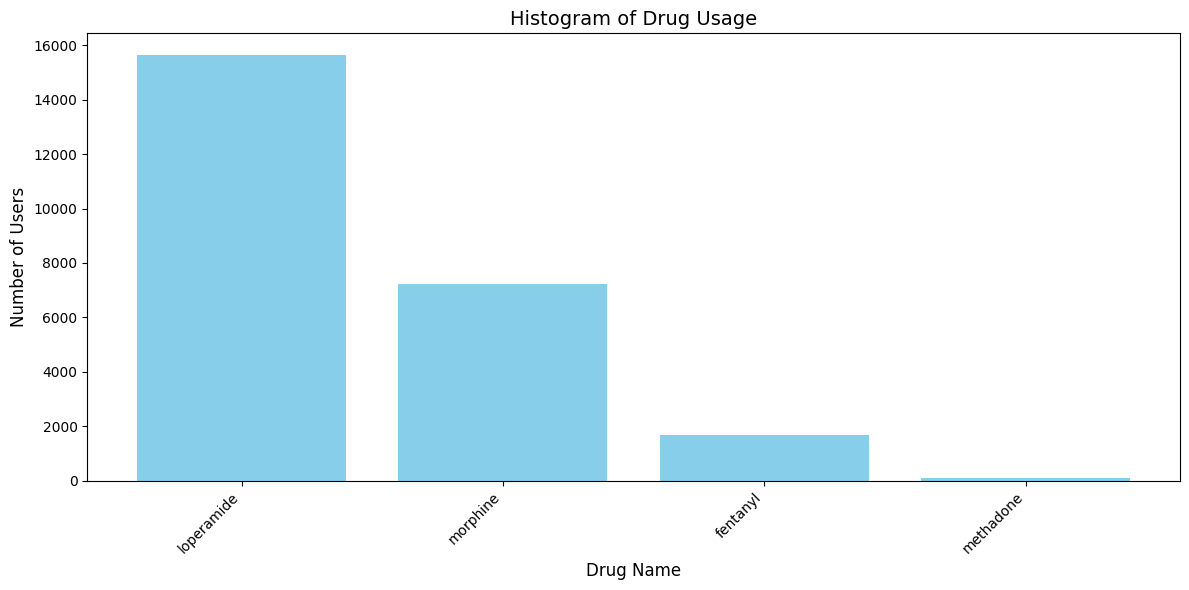

In [4]:
# Create the histogram
plt.figure(figsize=(12, 6))
eid_counts = data.groupby(["eid", "drug"]).size().reset_index(name="count")
drug_counts = eid_counts.groupby("drug").size().reset_index(name="count")
# Sort for better visualization
drug_counts = drug_counts.sort_values(by="count", ascending=False)
print(drug_counts)
# Sort for better visualization
drug_counts = drug_counts.sort_values(by="count", ascending=False)

plt.bar(drug_counts["drug"], drug_counts["count"], color="skyblue")
plt.xlabel("Drug Name", fontsize=12)
plt.ylabel("Number of Users", fontsize=12)
plt.title("Histogram of Drug Usage", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()

# Save the plot as an image file
plt.savefig("drug_usage_histogram.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

         drug  drug_exposure_count
3    morphine               113566
1  loperamide               106541
0    fentanyl                73888
2   methadone                 3181


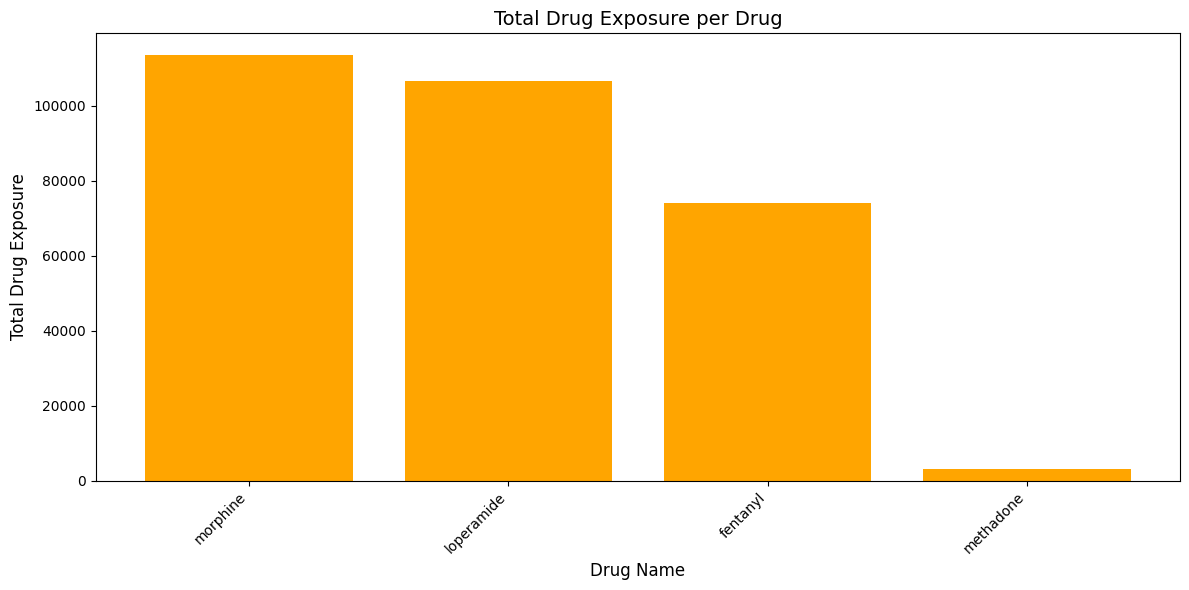

In [5]:
# Create the histogram for total drug_exposure_count
plt.figure(figsize=(12, 6))
drug_exposure_totals = data.groupby("drug")["drug_exposure_count"].sum().reset_index()

# Sort for better visualization
drug_exposure_totals = drug_exposure_totals.sort_values(
    by="drug_exposure_count", ascending=False
)
print(drug_exposure_totals)
plt.bar(
    drug_exposure_totals["drug"],
    drug_exposure_totals["drug_exposure_count"],
    color="orange",
)
plt.xlabel("Drug Name", fontsize=12)
plt.ylabel("Total Drug Exposure", fontsize=12)
plt.title("Total Drug Exposure per Drug", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()

# Save the plot as an image file
plt.savefig("total_drug_exposure_histogram.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

<Figure size 1200x800 with 0 Axes>

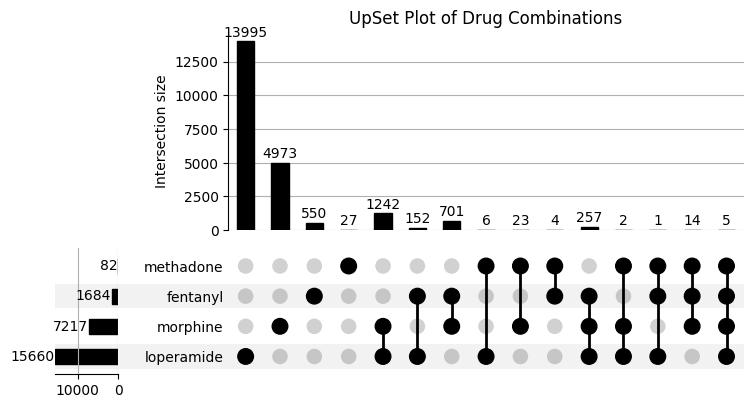

In [6]:
# Upset plot
# Create a set of drug combinations per person (eid)
# Each person will have a set of drugs they are taking
# Pivot the data to create a presence/absence matrix
binary_matrix = (
    data.groupby(["eid", "drug"])
    .size()
    .unstack(fill_value=0)
    .applymap(lambda x: 1 if x > 0 else 0)
)
# Count unique combinations
combination_counts = binary_matrix.groupby(list(binary_matrix.columns)).size()
# Create and plot the UpSet plot
upset = UpSet(combination_counts, show_counts=True, show_percentages=False)
plt.figure(figsize=(12, 8))
upset.plot()

plt.title("UpSet Plot of Drug Combinations")

# Save the plot as an image file
plt.savefig("upset_plot_drug_combinations.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

Now I will continue an anylisis of Morphine specifically

In [7]:
data_morphine = data[data["drug"] == "morphine"]

   gender  count
0  FEMALE   3907
1    MALE   3310


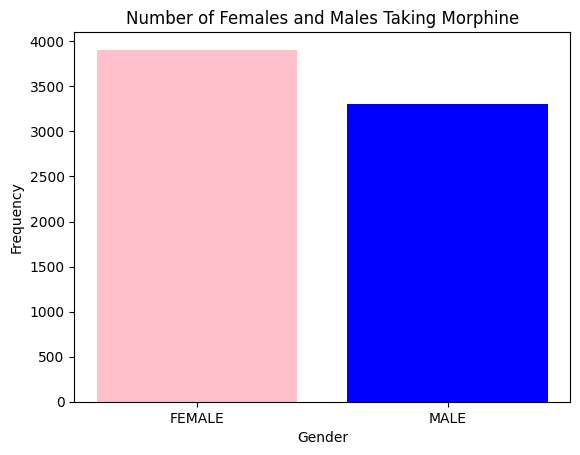

In [8]:
# Histogram of genders
eid_gender_counts = (
    data_morphine.groupby(["eid", "gender"]).size().reset_index(name="count")
)
gender_counts = eid_gender_counts.groupby("gender").size().reset_index(name="count")
print(gender_counts)
plt.bar(gender_counts["gender"], gender_counts["count"], color=["pink", "blue"])
plt.title("Number of Females and Males Taking Morphine")
plt.xlabel("Gender")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.savefig("gender_histogram_morphine.png", dpi=300, bbox_inches="tight")
plt.show()

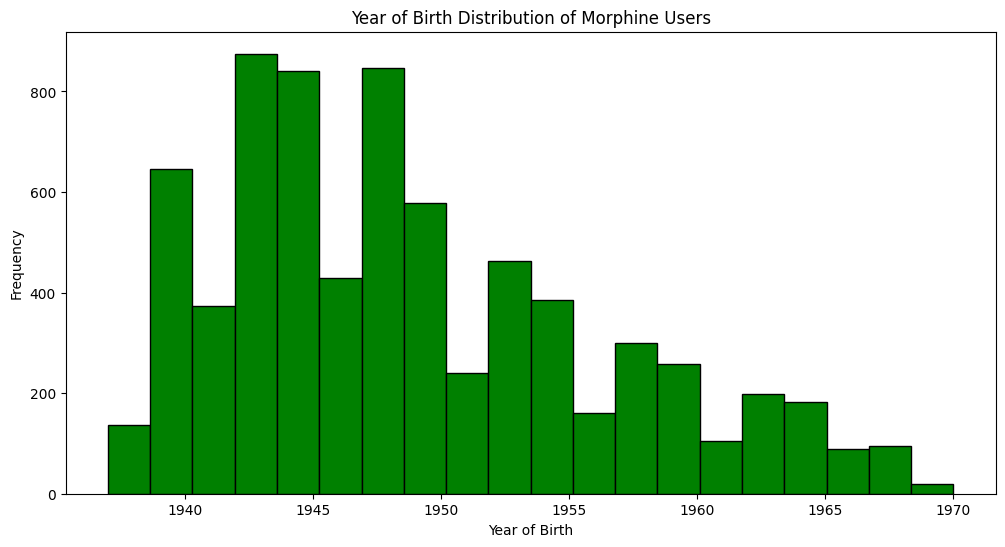

In [9]:
# Histogram of year of birth
eid_year_counts = (
    data_morphine.groupby(["eid", "year_of_birth"]).size().reset_index(name="count")
)
plt.figure(figsize=(12, 6))
plt.hist(eid_year_counts["year_of_birth"], bins=20, color="green", edgecolor="black")
plt.title("Year of Birth Distribution of Morphine Users")
plt.xlabel("Year of Birth")
plt.ylabel("Frequency")
plt.savefig("age_histogram_morphine.png", dpi=300, bbox_inches="tight")
plt.show()

In [10]:
data_morphine_sorted = data_morphine.sort_values(by="drug_era_id")
morphine_eras_count = (
    data_morphine_sorted.groupby("eid")
    .agg(
        num_drug_era_id=("drug_era_id", "nunique"),
        start_dates=("drug_era_start_date", list),
        end_dates=("drug_era_end_date", list),
        exposure_counts=("drug_exposure_count", list),
        gap_days=("gap_days", list),
    )
    .reset_index()
)
print(morphine_eras_count.drop("eid", axis=1))

      num_drug_era_id                         start_dates  \
0                   1                        [2013-06-02]   
1                   1                               [nan]   
2                   1                        [2013-08-04]   
3                   1                        [2015-07-05]   
4                   1                        [2015-11-09]   
...               ...                                 ...   
7212                4  [nan, 2013-12-12, nan, 2013-01-03]   
7213                2                          [nan, nan]   
7214                1                        [2003-05-08]   
7215                1                               [nan]   
7216                3       [2012-08-11, 2012-02-07, nan]   

                        end_dates exposure_counts       gap_days  
0                    [2013-12-03]             [2]            [0]  
1                    [2008-11-08]             [1]            [0]  
2                    [2014-05-04]            [51]           [37]  

In [11]:
# Analyze num_drug_era_id
print("Summary of num_drug_era_id:")
print(morphine_eras_count["num_drug_era_id"].describe())

# Total exposures per participant
morphine_eras_count["total_exposure_counts"] = morphine_eras_count[
    "exposure_counts"
].apply(sum)

# Analyze total exposure counts
print("\nSummary of total exposure:")
print(morphine_eras_count["total_exposure_counts"].describe())

# Average gap days per participant (ignoring NaN gaps)
morphine_eras_count["average_gap_days"] = morphine_eras_count["gap_days"].apply(
    lambda x: np.nanmean(x)
)  # Exclude NaN
# Calculate the standard deviation of exposure_counts to assess variability:
morphine_eras_count["exposure_counts_std"] = morphine_eras_count[
    "exposure_counts"
].apply(lambda x: np.nanstd(x))
print(morphine_eras_count.drop("eid", axis=1))

Summary of num_drug_era_id:
count    7217.000000
mean        2.077872
std         3.451562
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        80.000000
Name: num_drug_era_id, dtype: float64

Summary of total exposure:
count    7217.000000
mean       15.735901
std        44.949850
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max      1004.000000
Name: total_exposure_counts, dtype: float64
      num_drug_era_id                         start_dates  \
0                   1                        [2013-06-02]   
1                   1                               [nan]   
2                   1                        [2013-08-04]   
3                   1                        [2015-07-05]   
4                   1                        [2015-11-09]   
...               ...                                 ...   
7212                4  [nan, 2013-12-12, nan, 2013-01-03]   
7213                2                 

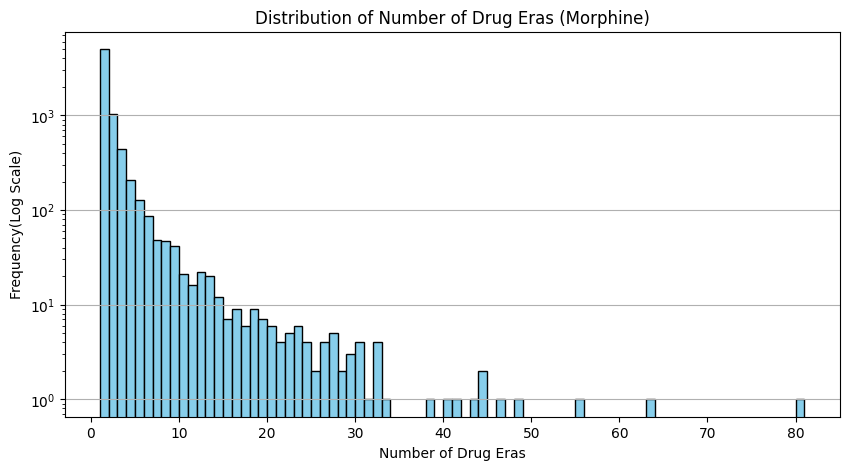

<Figure size 640x480 with 0 Axes>

In [12]:
# Visualize num_drug_era_id
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_eras_count["num_drug_era_id"],
    bins=range(1, morphine_eras_count["num_drug_era_id"].max() + 2),
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Number of Drug Eras (Morphine)")
plt.xlabel("Number of Drug Eras")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()
# Save the plot as an image file
plt.savefig("distribution_number_eras_morphine.png", dpi=300, bbox_inches="tight")

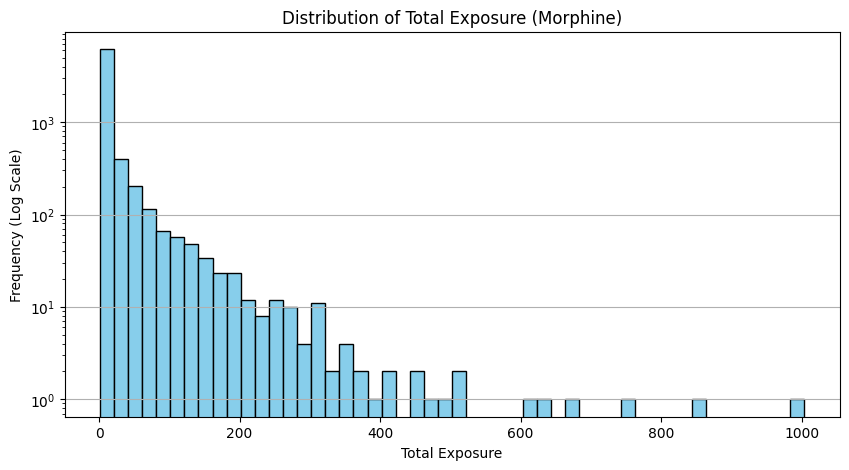

In [13]:
# Visualize total exposure counts
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_eras_count["total_exposure_counts"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.yscale("log")  # Logarithmic scale for y-axis
plt.title("Distribution of Total Exposure (Morphine)")
plt.xlabel("Total Exposure")
plt.ylabel("Frequency (Log Scale)")
plt.grid(axis="y")
# Save the plot as an image file
plt.savefig("distribution_total_exposure_morphine.png", dpi=300, bbox_inches="tight")

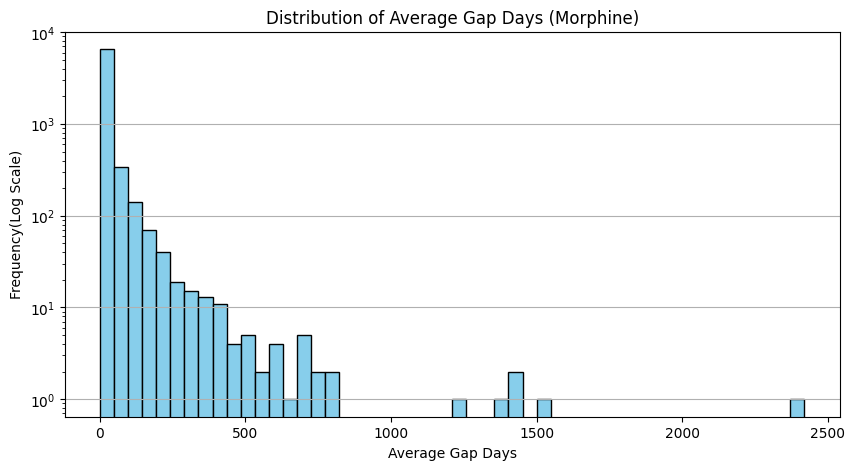

<Figure size 640x480 with 0 Axes>

In [14]:
# Visualize average gap days
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_eras_count["average_gap_days"].dropna(),
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Average Gap Days (Morphine)")
plt.xlabel("Average Gap Days")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()
# Save the plot as an image file
plt.savefig("distribution_average_gap_days_morphine.png", dpi=300, bbox_inches="tight")

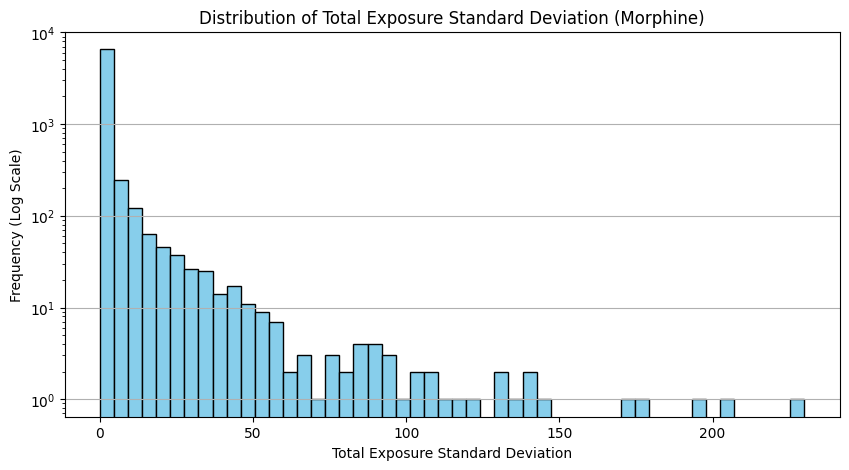

<Figure size 640x480 with 0 Axes>

In [15]:
# Distribution of total exposure standard deviation
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_eras_count["exposure_counts_std"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Total Exposure Standard Deviation (Morphine)")
plt.xlabel("Total Exposure Standard Deviation")
plt.ylabel("Frequency (Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()
plt.savefig(
    "distribution_total_exposure_std_morphine.png", dpi=300, bbox_inches="tight"
)

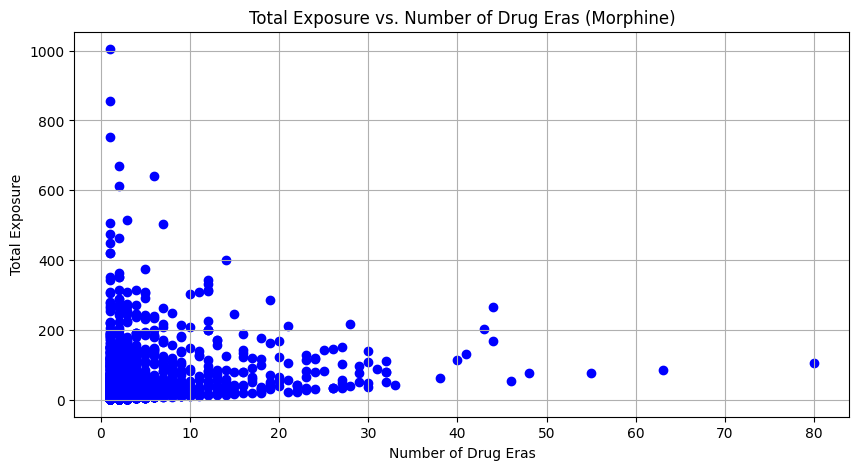


Correlation between num_drug_era_id and total_exposure_counts:
                       num_drug_era_id  total_exposure_counts
num_drug_era_id                1.00000                0.29535
total_exposure_counts          0.29535                1.00000


<Figure size 640x480 with 0 Axes>

In [16]:
# Correlation between num_drug_era_id and total exposure counts
plt.figure(figsize=(10, 5))
plt.scatter(
    morphine_eras_count["num_drug_era_id"],
    morphine_eras_count["total_exposure_counts"],
    c="blue",
)
plt.title("Total Exposure vs. Number of Drug Eras (Morphine)")
plt.xlabel("Number of Drug Eras")
plt.ylabel("Total Exposure")
plt.grid()
plt.show()
# Save the plot as an image file
plt.savefig("total_exposure_vs_drug_eras_morphine.png", dpi=300, bbox_inches="tight")

# Insights
print("\nCorrelation between num_drug_era_id and total_exposure_counts:")
print(morphine_eras_count[["num_drug_era_id", "total_exposure_counts"]].corr())

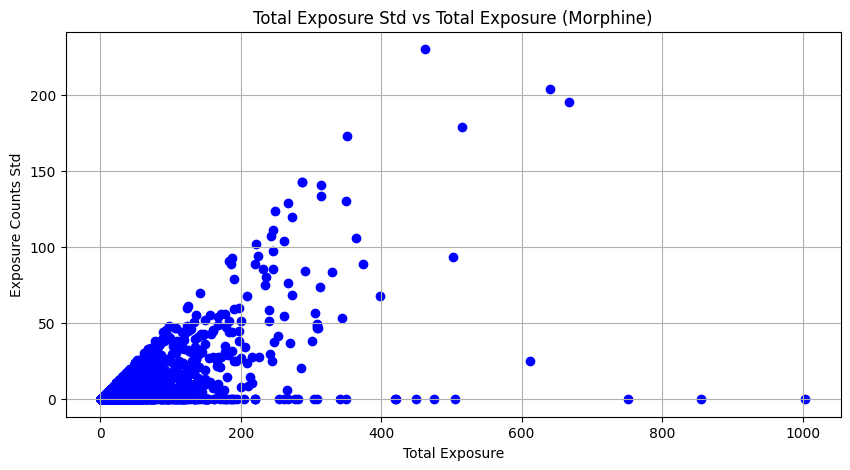

<Figure size 640x480 with 0 Axes>

In [17]:
# Total exposure std vs total exposure
plt.figure(figsize=(10, 5))
plt.scatter(
    morphine_eras_count["total_exposure_counts"],
    morphine_eras_count["exposure_counts_std"],
    c="blue",
)
plt.title("Total Exposure Std vs Total Exposure (Morphine)")
plt.xlabel("Total Exposure")
plt.ylabel("Exposure Counts Std")
plt.grid()
plt.show()
plt.savefig(
    "total_exposure_std_vs_total_exposure_morphine.png", dpi=300, bbox_inches="tight"
)

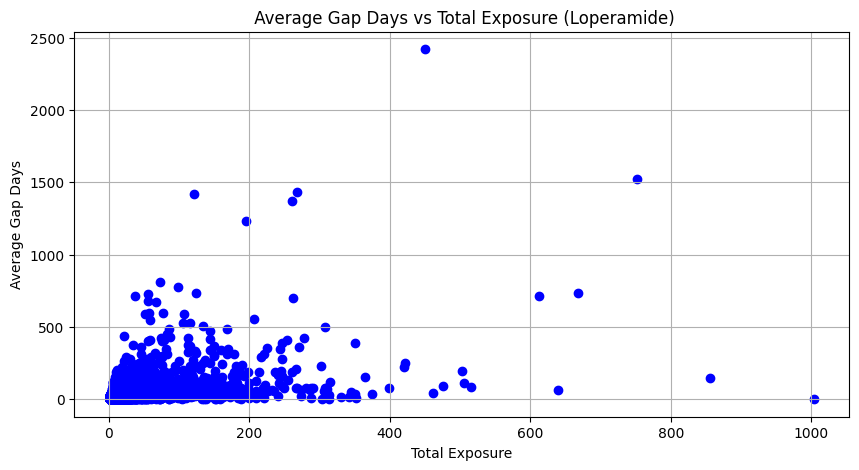

<Figure size 640x480 with 0 Axes>

In [18]:
# Average gap vs Total exposure
plt.figure(figsize=(10, 5))
plt.scatter(
    morphine_eras_count["total_exposure_counts"],
    morphine_eras_count["average_gap_days"],
    c="blue",
)
plt.title(" Average Gap Days vs Total Exposure (Loperamide)")
plt.xlabel("Total Exposure")
plt.ylabel("Average Gap Days")
plt.grid()
plt.show()
plt.savefig("average_gap_days_vs_total_exposure.png", dpi=300, bbox_inches="tight")

Now I will continue an anylisis of Loperamide specifically

In [19]:
data_loperamide = data[data["drug"] == "loperamide"]

   gender  count
0  FEMALE   9097
1    MALE   6563


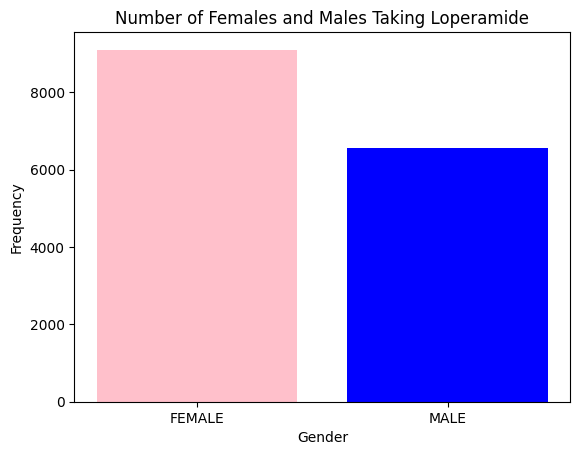

In [20]:
# Histogram of genders
eid_gender_counts = (
    data_loperamide.groupby(["eid", "gender"]).size().reset_index(name="count")
)
gender_counts = eid_gender_counts.groupby("gender").size().reset_index(name="count")
print(gender_counts)
plt.bar(gender_counts["gender"], gender_counts["count"], color=["pink", "blue"])
plt.title("Number of Females and Males Taking Loperamide")
plt.xlabel("Gender")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.savefig("gender_histogram_loperamide.png", dpi=300, bbox_inches="tight")
plt.show()

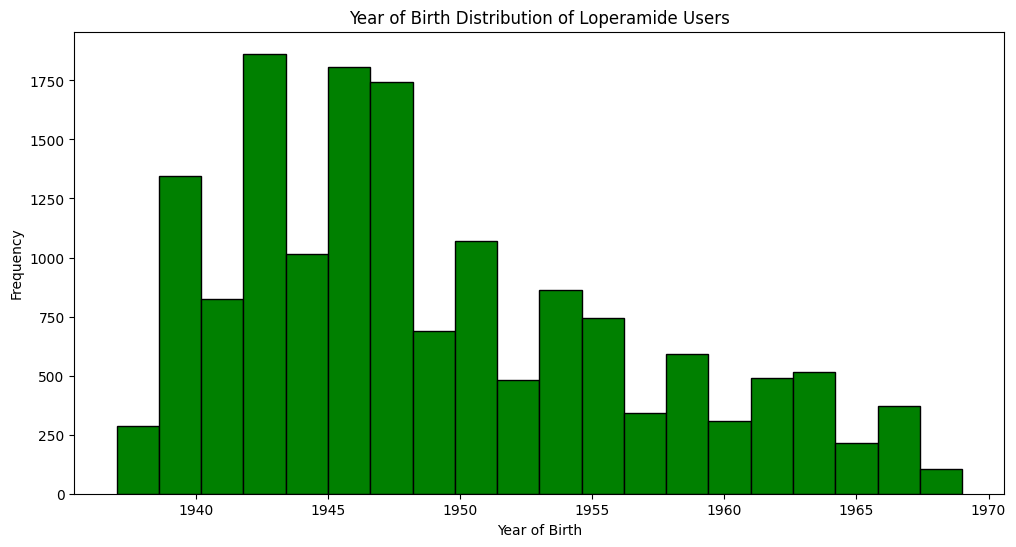

In [21]:
# Histogram of year of birth
eid_year_counts = (
    data_loperamide.groupby(["eid", "year_of_birth"]).size().reset_index(name="count")
)
plt.figure(figsize=(12, 6))
plt.hist(eid_year_counts["year_of_birth"], bins=20, color="green", edgecolor="black")
plt.title("Year of Birth Distribution of Loperamide Users")
plt.xlabel("Year of Birth")
plt.ylabel("Frequency")
plt.savefig("age_histogram_loperamide.png", dpi=300, bbox_inches="tight")
plt.show()

In [22]:
data_loperamide_sorted = data_loperamide.sort_values(by="drug_era_id")
loperamide_eras_count = (
    data_loperamide_sorted.groupby("eid")
    .agg(
        num_drug_era_id=("drug_era_id", "nunique"),
        start_dates=("drug_era_start_date", list),
        end_dates=("drug_era_end_date", list),
        exposure_counts=("drug_exposure_count", list),
        gap_days=("gap_days", list),
    )
    .reset_index()
)
print(loperamide_eras_count.drop("eid", axis=1))

       num_drug_era_id        start_dates                 end_dates  \
0                    1       [2013-07-05]              [2013-09-05]   
1                    1              [nan]              [2002-03-04]   
2                    1              [nan]                     [nan]   
3                    1              [nan]                     [nan]   
4                    1       [2013-08-07]                     [nan]   
...                ...                ...                       ...   
15655                2  [1998-02-11, nan]         [1998-07-11, nan]   
15656                1              [nan]                     [nan]   
15657                2         [nan, nan]  [2002-05-10, 1997-04-10]   
15658                1              [nan]                     [nan]   
15659                1       [2012-10-12]                     [nan]   

      exposure_counts gap_days  
0                 [1]      [0]  
1                 [1]      [0]  
2                 [1]      [0]  
3              

In [23]:
# Analyze num_drug_era_id
print("Summary of num_drug_era_id:")
print(loperamide_eras_count["num_drug_era_id"].describe())

# Total exposures per participant
loperamide_eras_count["total_exposure_counts"] = loperamide_eras_count[
    "exposure_counts"
].apply(sum)

# Analyze total exposure counts
print("\nSummary of total exposure:")
print(loperamide_eras_count["total_exposure_counts"].describe())

# Average gap days per participant (ignoring NaN gaps)
loperamide_eras_count["average_gap_days"] = loperamide_eras_count["gap_days"].apply(
    lambda x: np.nanmean(x)
)  # Exclude NaN

# Calculate the standard deviation of exposure_counts to assess variability:
loperamide_eras_count["exposure_counts_std"] = loperamide_eras_count[
    "exposure_counts"
].apply(lambda x: np.nanstd(x))
print(loperamide_eras_count.drop("eid", axis=1))

Summary of num_drug_era_id:
count    15660.000000
mean         3.456705
std          7.184902
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        103.000000
Name: num_drug_era_id, dtype: float64

Summary of total exposure:
count    15660.000000
mean         6.803384
std         19.541310
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        420.000000
Name: total_exposure_counts, dtype: float64
       num_drug_era_id        start_dates                 end_dates  \
0                    1       [2013-07-05]              [2013-09-05]   
1                    1              [nan]              [2002-03-04]   
2                    1              [nan]                     [nan]   
3                    1              [nan]                     [nan]   
4                    1       [2013-08-07]                     [nan]   
...                ...                ...                       ...   
15655        

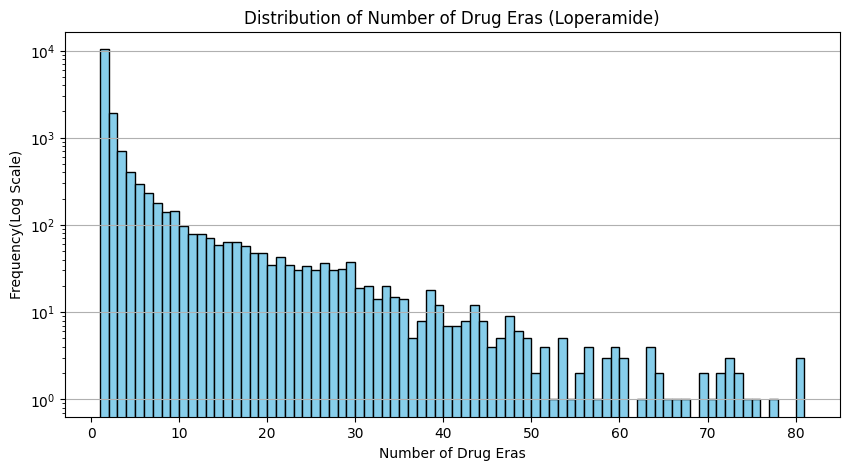

<Figure size 640x480 with 0 Axes>

In [24]:
# Visualize num_drug_era_id
plt.figure(figsize=(10, 5))
plt.hist(
    loperamide_eras_count["num_drug_era_id"],
    bins=range(1, morphine_eras_count["num_drug_era_id"].max() + 2),
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Number of Drug Eras (Loperamide)")
plt.xlabel("Number of Drug Eras")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()
# Save the plot as an image file
plt.savefig("distribution_number_eras_loperamide.png", dpi=300, bbox_inches="tight")

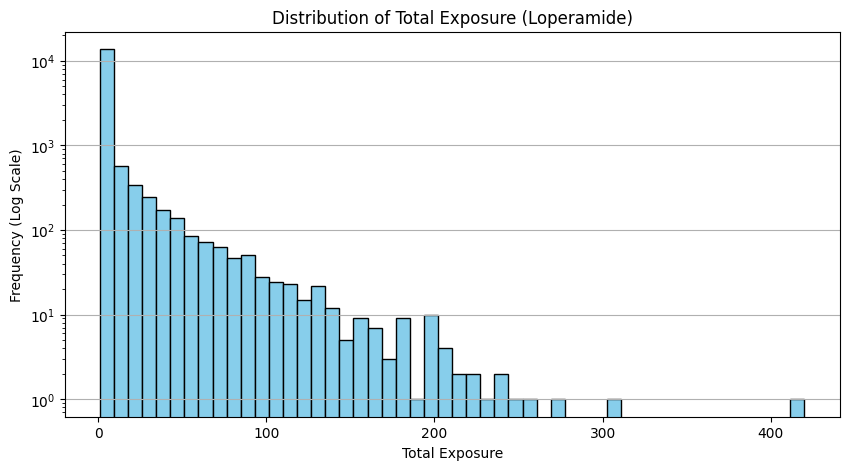

In [25]:
# Visualize total exposure counts
plt.figure(figsize=(10, 5))
plt.hist(
    loperamide_eras_count["total_exposure_counts"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.yscale("log")  # Logarithmic scale for y-axis
plt.title("Distribution of Total Exposure (Loperamide)")
plt.xlabel("Total Exposure")
plt.ylabel("Frequency (Log Scale)")
plt.grid(axis="y")
# Save the plot as an image file
plt.savefig("distribution_total_exposure_loperamide.png", dpi=300, bbox_inches="tight")

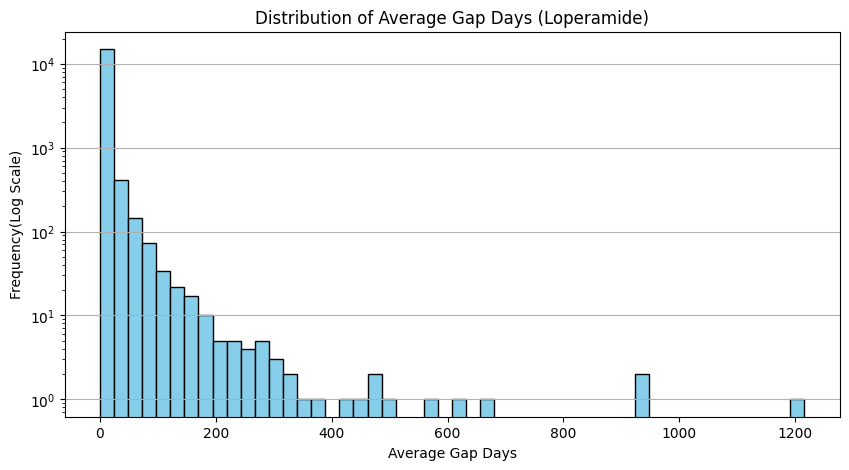

<Figure size 640x480 with 0 Axes>

In [26]:
# Visualize average gap days
plt.figure(figsize=(10, 5))
plt.hist(
    loperamide_eras_count["average_gap_days"].dropna(),
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Average Gap Days (Loperamide)")
plt.xlabel("Average Gap Days")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()
# Save the plot as an image file
plt.savefig(
    "distribution_average_gap_days_loperamide.png", dpi=300, bbox_inches="tight"
)

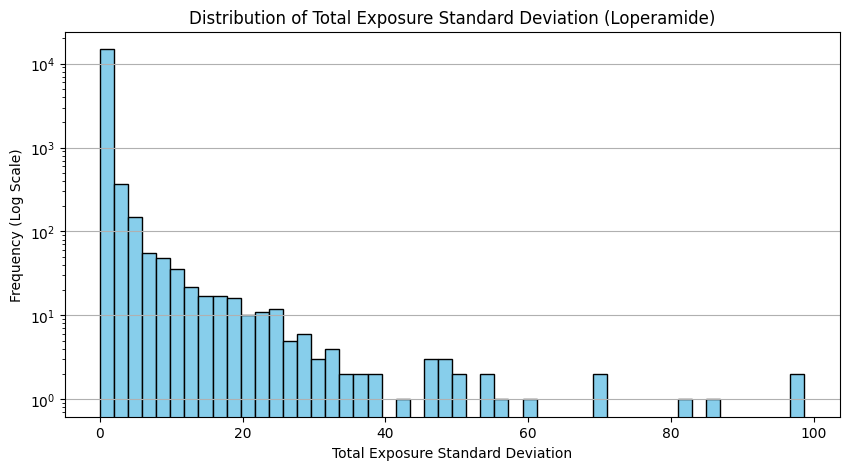

<Figure size 640x480 with 0 Axes>

In [27]:
# Distribution of total exposure standard deviation
plt.figure(figsize=(10, 5))
plt.hist(
    loperamide_eras_count["exposure_counts_std"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Total Exposure Standard Deviation (Loperamide)")
plt.xlabel("Total Exposure Standard Deviation")
plt.ylabel("Frequency (Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()
plt.savefig(
    "distribution_total_exposure_std_loperamide.png", dpi=300, bbox_inches="tight"
)

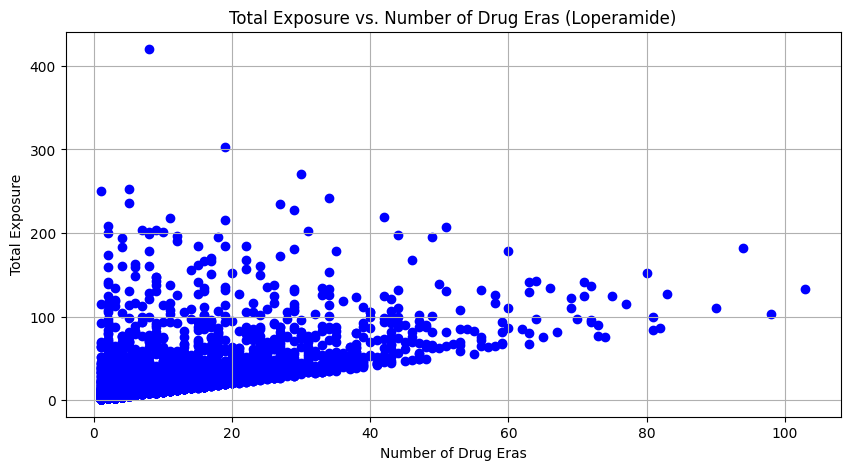


Correlation between num_drug_era_id and total_exposure_counts:
                       num_drug_era_id  total_exposure_counts
num_drug_era_id                1.00000                0.68717
total_exposure_counts          0.68717                1.00000


<Figure size 640x480 with 0 Axes>

In [28]:
# Correlation between num_drug_era_id and total exposure counts
plt.figure(figsize=(10, 5))
plt.scatter(
    loperamide_eras_count["num_drug_era_id"],
    loperamide_eras_count["total_exposure_counts"],
    c="blue",
)
plt.title("Total Exposure vs. Number of Drug Eras (Loperamide)")
plt.xlabel("Number of Drug Eras")
plt.ylabel("Total Exposure")
plt.grid()
plt.show()
# Save the plot as an image file
plt.savefig("total_exposure_vs_drug_eras_loperamide.png", dpi=300, bbox_inches="tight")

# Insights
print("\nCorrelation between num_drug_era_id and total_exposure_counts:")
print(loperamide_eras_count[["num_drug_era_id", "total_exposure_counts"]].corr())

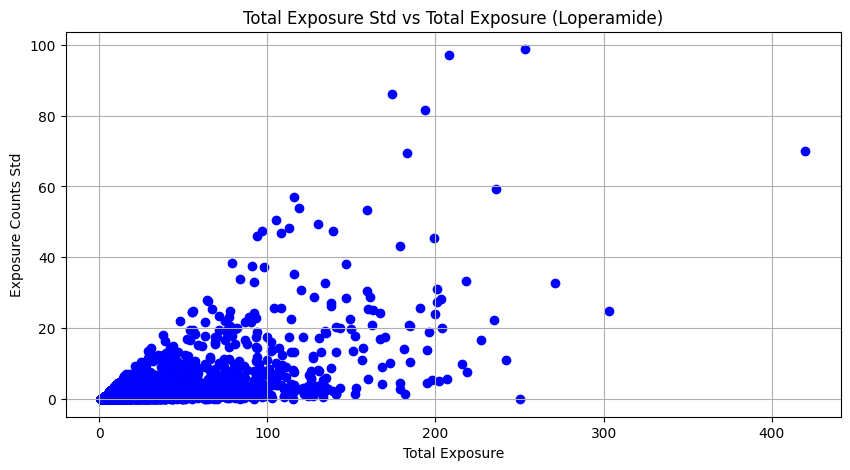

<Figure size 640x480 with 0 Axes>

In [29]:
# Total exposure std vs total exposure
plt.figure(figsize=(10, 5))
plt.scatter(
    loperamide_eras_count["total_exposure_counts"],
    loperamide_eras_count["exposure_counts_std"],
    c="blue",
)
plt.title("Total Exposure Std vs Total Exposure (Loperamide)")
plt.xlabel("Total Exposure")
plt.ylabel("Exposure Counts Std")
plt.grid()
plt.show()
plt.savefig(
    "total_exposure_std_vs_total_exposure_loperamide.png", dpi=300, bbox_inches="tight"
)

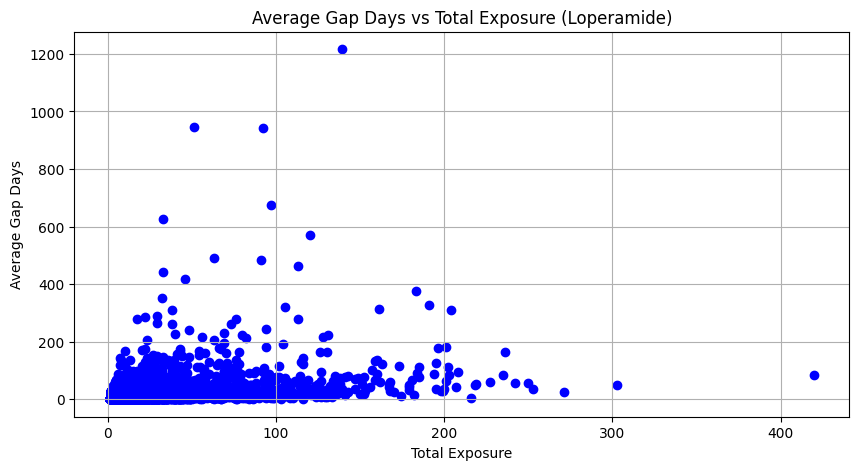

<Figure size 640x480 with 0 Axes>

In [30]:
# Average gap vs Total exposure
plt.figure(figsize=(10, 5))
plt.scatter(
    loperamide_eras_count["total_exposure_counts"],
    loperamide_eras_count["average_gap_days"],
    c="blue",
)
plt.title("Average Gap Days vs Total Exposure (Loperamide)")
plt.xlabel("Total Exposure")
plt.ylabel("Average Gap Days")
plt.grid()
plt.show()
plt.savefig(
    "average_gap_days_vs_total_exposure_loperamide.png", dpi=300, bbox_inches="tight"
)

How to do Adherence Study: 
Instead of relying on start_dates and end_dates (mostly null), we can use:

a. Number of Drug Eras (num_drug_era_id):
Participants with a higher number of drug eras might indicate irregular or fragmented drug usage, suggesting potential non-adherence.

b. Total Exposure Counts (total_exposure_counts):
Higher values may correlate with adherence, as consistent exposure counts indicate continued drug usage.

c. Average Gap Days (average_gap_days):
Smaller gaps between drug exposures suggest adherence, while larger or inconsistent gaps indicate non-adherence.

d. Consistency in Exposure Counts (exposure_counts):
We can measure variability in exposure_counts across eras for each participant. A low standard deviation implies more consistent drug usage.

Calculate a score: df['adherence_score'] = (
    df['total_exposure_counts'] -  # Higher exposure counts are better
    (df['average_gap_days']) -  # Smaller gaps are better
    (df['exposure_counts_std'])  # Lower variability is better
)

Summary of adherence_score with more than 1 exposure:
count    4772.000000
mean       -0.079982
std         1.321523
min       -23.562244
25%        -0.069819
50%         0.178353
75%         0.200602
max        22.471407
Name: adherence_score_omop, dtype: float64


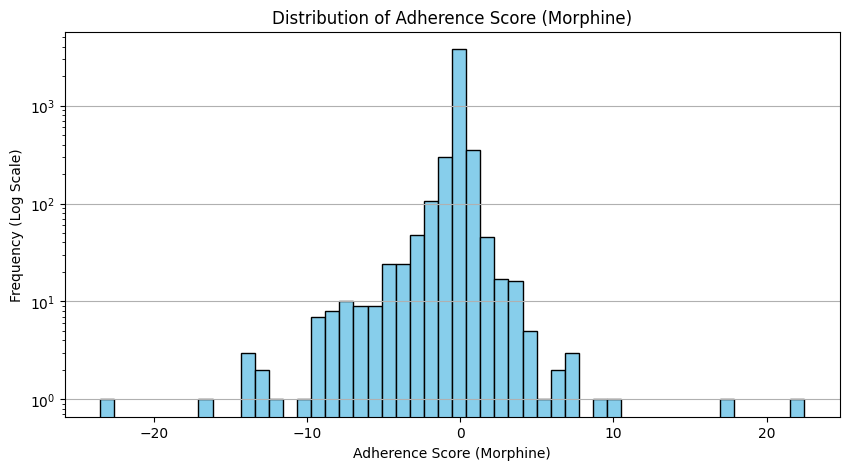

<Figure size 640x480 with 0 Axes>

In [34]:
# Include adherence score for Morphine normalizing each feature:
# Initialize the scaler
scaler = StandardScaler()
morphine_eras_count["adherence_score_omop"] = (
    scaler.fit_transform(
        morphine_eras_count["total_exposure_counts"].values.reshape(-1, 1)
    )  # Higher exposure counts are better
    - scaler.fit_transform(
        (morphine_eras_count["average_gap_days"].values.reshape(-1, 1))
    )  # Smaller gaps are better
    - scaler.fit_transform(
        (morphine_eras_count["exposure_counts_std"].values.reshape(-1, 1))
    )  # Lower variability is better
)
print("Summary of adherence_score with more than 1 exposure:")
print(morphine_eras_count[morphine_eras_count["total_exposure_counts"] > 1]["adherence_score_omop"].describe())

# Distribution of adherence score for people with more than 1 exposure
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_eras_count[morphine_eras_count["total_exposure_counts"] > 1][
        "adherence_score_omop"
    ],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Adherence Score (Morphine)")
plt.xlabel("Adherence Score (Morphine)")
plt.ylabel("Frequency (Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()
# Save the plot as an image file
plt.savefig("distribution_adherence_score_morphine.png", dpi=300, bbox_inches="tight")

Summary of adherence_score with more than 1 exposure:
count    5944.000000
mean       -0.081321
std         2.119579
min       -55.503069
25%        -0.079129
50%         0.100926
75%         0.254451
max        10.618939
Name: adherence_score_omop, dtype: float64


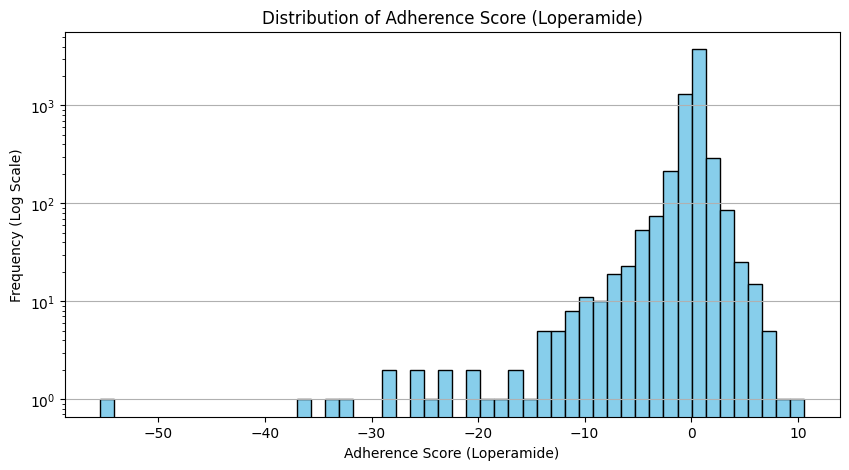

<Figure size 640x480 with 0 Axes>

In [36]:
# Include adherence score for Loperamide normalizing each feature:
# Initialize the scaler
scaler = StandardScaler()
loperamide_eras_count["adherence_score_omop"] = (
    scaler.fit_transform(
        loperamide_eras_count["total_exposure_counts"].values.reshape(-1, 1)
    )  # Higher exposure counts are better
    - scaler.fit_transform(
        (loperamide_eras_count["average_gap_days"].values.reshape(-1, 1))
    )  # Smaller gaps are better
    - scaler.fit_transform(
        (loperamide_eras_count["exposure_counts_std"].values.reshape(-1, 1))
    )  # Lower variability is better
)
print("Summary of adherence_score with more than 1 exposure:")
print(loperamide_eras_count[loperamide_eras_count["total_exposure_counts"] > 1]["adherence_score_omop"].describe())

# Distribution of adherence score
plt.figure(figsize=(10, 5))
plt.hist(
    loperamide_eras_count[loperamide_eras_count["total_exposure_counts"] > 1][
        "adherence_score_omop"
    ],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Adherence Score (Loperamide)")
plt.xlabel("Adherence Score (Loperamide)")
plt.ylabel("Frequency (Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()
# Save the plot as an image file
plt.savefig("distribution_adherence_score_loperamide.png", dpi=300, bbox_inches="tight")

In [37]:
loperamide_eras_count.to_csv("omop_loperamide_groupbyeid.csv", index=False)
morphine_eras_count.to_csv("omop_morphine_groupbyeid.csv", index=False)